# Parametric Component Library

[Components](../_autosummary/photonforge.Component.rst) are the building blocks for all devices in PhotonForge.
Besides those [provided by PDKs](PDK_Components.ipynb), PhotonForge offers a growing number of [parametric components](../parametric.rst) that can be used to build photonic circuits.
They are built to be used with any [technology](Technology.ipynb), so that we can freely mix them with PDK-provided components to create larger systems.

We can use both the included [basic technology](../_autosummary/photonforge.basic_technology.rst) and the [SiEPIC OpenEBL](https://siepic.ca/openebl/) PDK through the `siepic_forge` module to show the parametric components working on different technologies.

In [1]:
import photonforge as pf
import siepic_forge as siepic

# Create 2 technologies for comparison
siepic_tech = siepic.ebeam()
basic_tech = pf.basic_technology()

# Use the SiEPIC PDK as project default
pf.config.default_technology = siepic_tech

One parameter that most parametric components require is a [port specification](Ports.ipynb) to define their ports and waveguides.
We can recall the port specifications available in each technology:

In [2]:
print("SiEPIC ports:\n" + ", ".join(siepic_tech.ports.keys()))
print("\nBasic Technology ports:\n" + ", ".join(basic_tech.ports.keys()))

SiEPIC ports:
SiN_TE_1310_750, TE_1550_500, TE_1310_410, SiN_TE_895_450, SiN_TM_1310_750, TE_1310_350, SiN_TE_1310_800, TM_1310_350, TM_1550_500, SiN_TE-TM_1550_1000, SiN_TM_1550_1000, SiN_TE_1550_1000, SiN_TE_1550_800, Rib_TE_1550_500, TE-TM_1550_450, Rib_TE_1310_350, MM_TE_1550_2000, MM_TE_1550_3000, MM_SiN_TE_1550_3000, Slot_TE_1550_500, SiN_TE_1550_750, eskid_TE_1550

Basic Technology ports:
CPW, Rib, Strip


Creating the actual component is straightforward.
We'll use the "TE_1550_500" waveguide from SiEPIC to create a 10 μm [straight waveguide section](../_autosummary/photonforge.parametric.straight.rst):

In [3]:
straight = pf.parametric.straight(port_spec="TE_1550_500", length=10)
straight

Creating an [S bend](../_autosummary/photonforge.parametric.s_bend.rst) for the same port specification is also simple:

In [4]:
s_bend = pf.parametric.s_bend(port_spec="TE_1550_500", length=8, offset=2)
s_bend

For comparison, here's the same S bend created for the basic technology we generated earlier.
Note that, because we're not using the [default technology](../config.rst#photonforge.config.default_technology), we have to specify the technology we want to use.

In [5]:
s_bend_basic = pf.parametric.s_bend(
    port_spec="Strip", length=8, offset=2, technology=basic_tech
)
s_bend_basic

## Caching

Parametric components are cached by default, which means that when called multiple times with the same arguments, the same component will be returned, unless that component has been modified.
For example, if we recreate the S bend, we'll get the same component as before.

In [6]:
s_bend_cached = pf.parametric.s_bend(
    port_spec="Strip", length=8, offset=2, technology=basic_tech
)
s_bend_cached is s_bend_basic

True

The cache can be skipped with `use_parametric_cache=False`:

In [7]:
s_bend_non_cached = pf.parametric.s_bend(
    port_spec="Strip",
    length=8,
    offset=2,
    technology=basic_tech,
    use_parametric_cache=False,
)
s_bend_non_cached is s_bend_basic

False

## Component Updates

Parametric components can be updated after creation by setting new keyword argument parameters to the [update](../_autosummary/photonforge.Component.rst#photonforge.Component.update) function:

In [8]:
s_bend.update(port_spec="Slot_TE_1550_500", length=6)

**Attention:** component updates reset any component changes added after creation because it re-instantiates the component contents from its original function.
For example, if we add a new model to the component, it will be lost after an update:

In [9]:
s_bend.add_model(pf.WaveguideModel(n_complex=2.0 + 0.1j), "BadModel")
assert "BadModel" in s_bend.models

s_bend.update(port_spec="Rib_TE_1550_500", offset=1)
assert "BadModel" not in s_bend.models

s_bend

The parametric information stored in the component can be inspected with the [parametric_function](../_autosummary/photonforge.Component.rst#photonforge.Component.parametric_function) and [parametric_kwargs](../_autosummary/photonforge.Component.rst#photonforge.Component.parametric_kwargs) attributes:

In [10]:
print("Parametric function name:", s_bend.parametric_function)
print("Parametric kwargs:", s_bend.parametric_kwargs)

Parametric function name: photonforge.parametric.s_bend
Parametric kwargs: {'port_spec': 'Rib_TE_1550_500', 'length': 6, 'offset': 1, 'euler_fraction': None, 'active_model': None, 'technology': None, 'name': None, 'tidy3d_model_kwargs': None, 'waveguide_model_kwargs': None}


## Simulation

Parametric components include the models that are meaningful for them.
Most include a [Tidy3D model](Tidy3D_Model.ipynb) and, when applicable, an analytical one.
Therefore, simulating them can be as simple as:

Loading cached simulation from .tidy3d/pf_cache/EF3/ms_info-UNNCMKAPZ3TSCEAUVR3P5AUEDRR2FY7RT7IIY3EHKU5FNL2O2HUQ.json.
Progress: 100% 


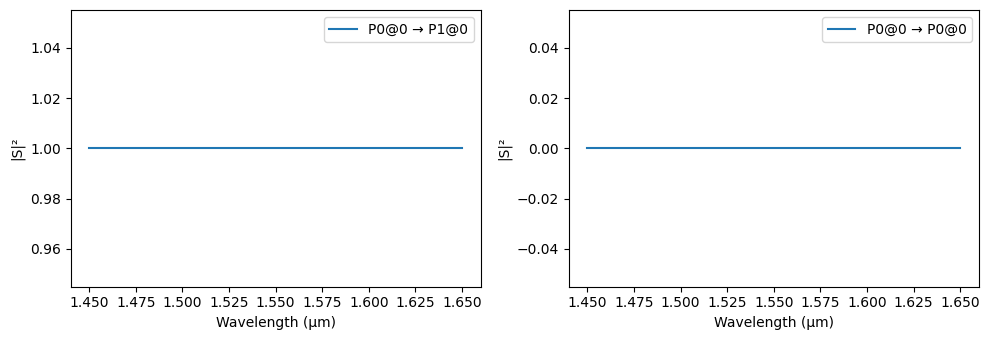

In [11]:
import numpy as np

s_matrix = s_bend.s_matrix(pf.C_0 / np.linspace(1.45, 1.65, 11))
_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"])

The S bend uses a semi-analytical [waveguide model](../_autosummary/photonforge.WaveguideModel.rst) by default, which assumes the bend has no significant radiation losses.
We can use Tidy3D to get more realistic S parameters through FDTD.
The warnings can be ignored in this case: they come from the slabs touching the simulation boundaries, as they are meant to.

15:59:56 -03 WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 1 WARNING message.                             

Loading cached simulation from .tidy3d/pf_cache/VMO/fdtd_info-NLI2F46DQU6EMAKRFEDH7W3QIHMYUGLSWR6NCRXHHH33BTJNIHJA.json.


             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 1 WARNING message.                             

Progress: 100% 


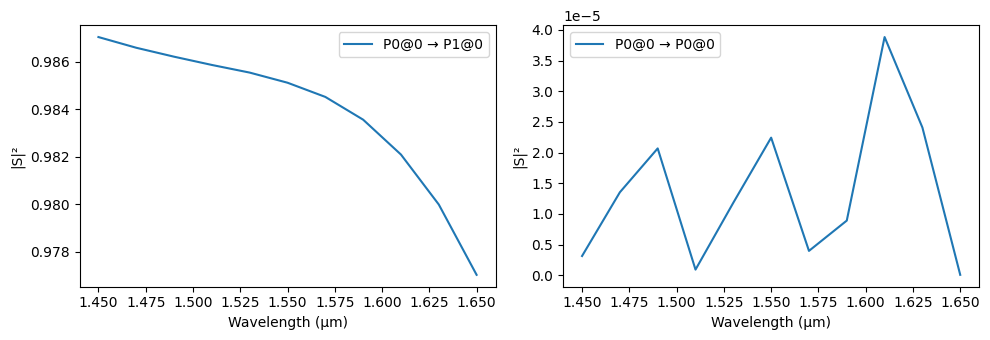

In [12]:
s_bend.activate_model("Tidy3D")

s_matrix = s_bend.s_matrix(pf.C_0 / np.linspace(1.45, 1.65, 11))
_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"])

## Default Arguments

In many cases, the same arguments will be user over and over when creating parametric components.
To avoid repetition and help with automation, we can preset keyword arguments for the parametric components using [config.default_kwargs](../config.rst#photonforge.config.default_kwargs).
For example, if we define a default port specification, we don't need to pass it when creating the component:

In [13]:
pf.config.default_kwargs["port_spec"] = "TE_1550_500"

pf.parametric.straight(length=10)

In some cases, it is desirable to set a default only for a specific component.
For example, both [bend](../_autosummary/photonforge.parametric.bend.rst) and [s_bend](../_autosummary/photonforge.parametric.s_bend.rst) have a `euler_fraction` argument.
If we want to set different defaults for each (or maybe only for one of them), we can do so using a sub-dictionary with the function name:

In [14]:
pf.config.default_kwargs["bend"] = {"euler_fraction": 0}
pf.config.default_kwargs["s_bend"] = {"euler_fraction": 1}

# References used only to show both components simultaneously
pf.Component().add(
    pf.Reference(pf.parametric.bend(radius=4)),
    pf.Reference(pf.parametric.s_bend(length=6, offset=3), (5, 0))
)

Finally, defaults can still be overridden at the function call:

In [15]:
pf.parametric.bend(radius=4, euler_fraction=1)